 ***Paddy Leaf Disease Classification***

### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE_W = 256
IMAGE_SIZE_H = 256
CHANNELS=3
EPOCHS=30

### Import data into tensorflow dataset object

In [11]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    seed=123,
    shuffle=True,
    #color_mode='grayscale',
    image_size=(IMAGE_SIZE_W,IMAGE_SIZE_H),
    batch_size=BATCH_SIZE
)


Found 10407 files belonging to 10 classes.


In [12]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 4 5 9 9 3 0 5 7 4 3 4 0 3 6 8 8 9 9 4 5 2 2 5 9 8 5 7 6 8 5 4]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

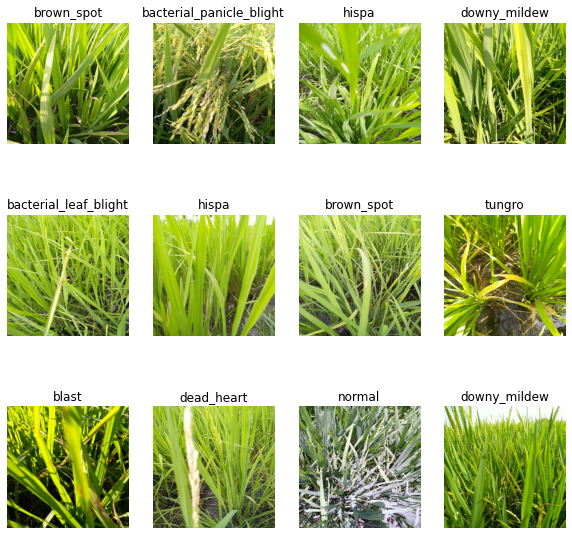

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [15]:
len(dataset)

326

In [16]:
train_size = 0.7
len(dataset)*train_size

228.2

In [17]:
train_ds = dataset.take(228)
len(train_ds)

228

In [18]:
test_ds = dataset.skip(228)
len(test_ds)

98

In [19]:
val_size=0.15
len(dataset)*val_size

48.9

In [20]:
val_ds = test_ds.take(48)
len(val_ds)

48

In [21]:
test_ds = test_ds.skip(48)
len(test_ds)

50

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

260

In [25]:
len(val_ds)

32

In [26]:
len(test_ds)

34

### Cache, Shuffle, and Prefetch the Dataset

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [28]:
resize_and_rescale = tf.keras.Sequential([
  #tf.image.rgb_to_grayscale(input_images)
  #layers.experimental.preprocessing.GaussianNoise(stddev),
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE_W, IMAGE_SIZE_H),
  layers.experimental.preprocessing.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds= val_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE_W, IMAGE_SIZE_H, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
  
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (32, 254, 254, 16)        448       
                                                                 
 batch_normalization_4 (Batc  (32, 254, 254, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (32, 125, 125, 32)        4640      
                                                                 
 batch_normalization_5 (Batc  (32, 125, 125, 32)      

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
260/260 [==============================] - 318s 1s/step - loss: 1.8116 - accuracy: 0.3741 - val_loss: 2.7779 - val_accuracy: 0.1670
Epoch 2/30
260/260 [==============================] - 271s 1s/step - loss: 1.3386 - accuracy: 0.5455 - val_loss: 2.4690 - val_accuracy: 0.2812
Epoch 3/30
260/260 [==============================] - 271s 1s/step - loss: 1.1009 - accuracy: 0.6304 - val_loss: 1.7669 - val_accuracy: 0.4375
Epoch 4/30
260/260 [==============================] - 262s 1s/step - loss: 0.9345 - accuracy: 0.6879 - val_loss: 1.2419 - val_accuracy: 0.5859
Epoch 5/30
260/260 [==============================] - 265s 1s/step - loss: 0.8161 - accuracy: 0.7286 - val_loss: 1.9743 - val_accuracy: 0.4453
Epoch 6/30
260/260 [==============================] - 276s 1s/step - loss: 0.7362 - accuracy: 0.7595 - val_loss: 1.0210 - val_accuracy: 0.6553
Epoch 7/30
260/260 [==============================] - 261s 1s/step - loss: 0.6283 - accuracy: 0.8004 - val_loss: 1.0856 - val_accuracy: 0.6436

In [56]:
scores = model.evaluate(test_ds)

34/34 [==============================] - 41s 285ms/step - loss: 0.6126 - accuracy: 0.8254


In [57]:
scores

[0.6126461029052734, 0.8253676295280457]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [58]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [59]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 260}

In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [61]:
type(history.history['loss'])

list

In [62]:
len(history.history['loss'])

30

In [63]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8116172552108765,
 1.338570475578308,
 1.1008931398391724,
 0.9345020055770874,
 0.8161088824272156]

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

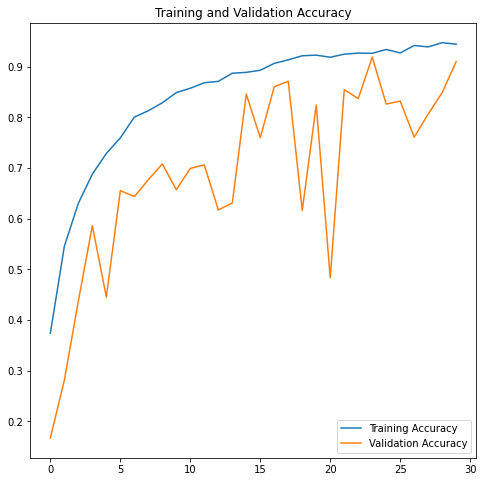

In [81]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



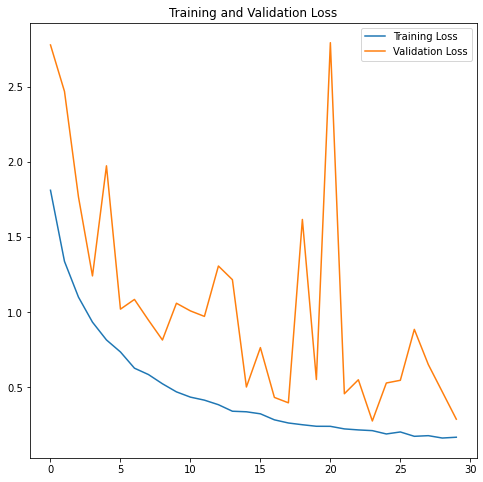

In [82]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 334ms/step
(1, 254, 254, 16)
(1, 254, 254, 16)
(1, 127, 127, 16)
(1, 125, 125, 32)
(1, 125, 125, 32)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23288\3461415455.py:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23288\3461415455.py:39: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std ()


(1, 62, 62, 32)
(1, 60, 60, 32)
(1, 60, 60, 32)
(1, 30, 30, 32)
(1, 28, 28, 64)
(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 12, 12, 64)
(1, 12, 12, 64)
(1, 6, 6, 64)
(1, 4, 4, 64)
(1, 4, 4, 64)
(1, 2, 2, 64)
(1, 256)
(1, 64)
(1, 10)


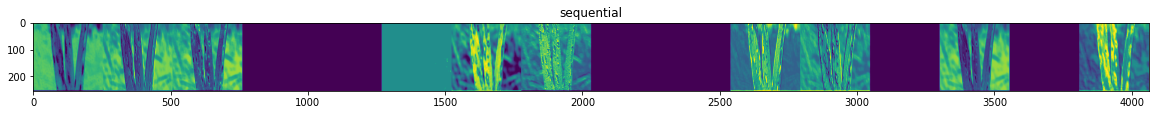

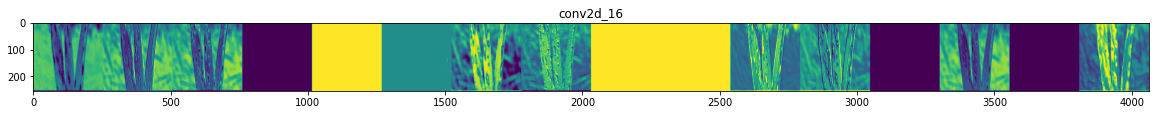

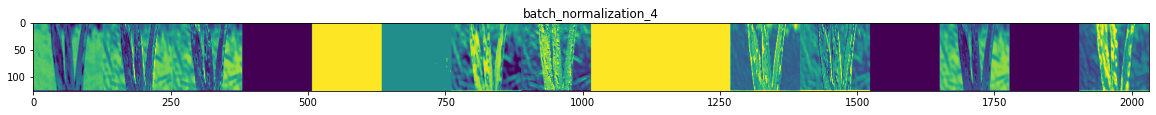

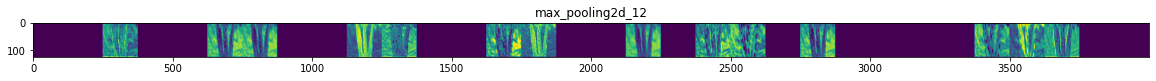

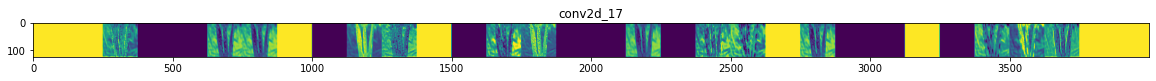

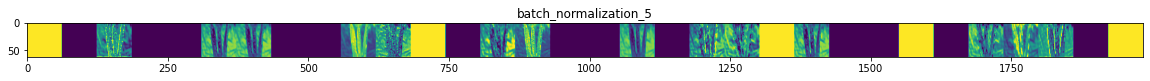

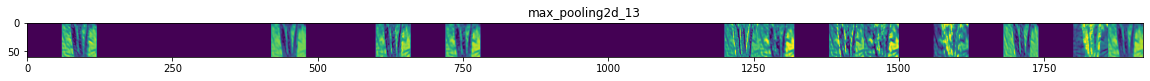

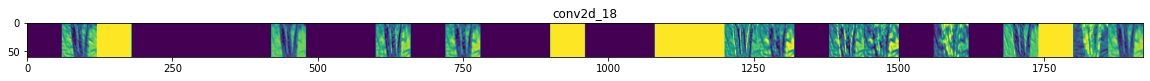

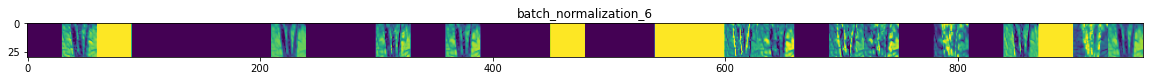

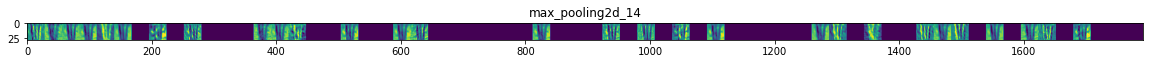

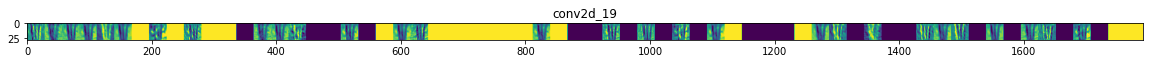

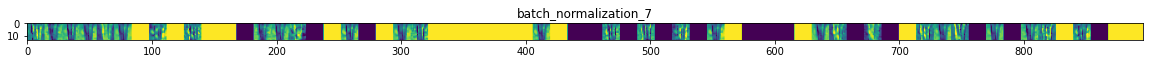

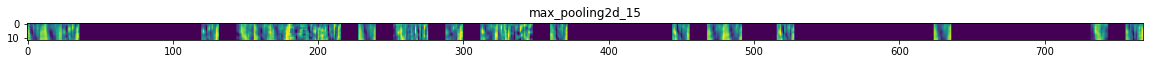

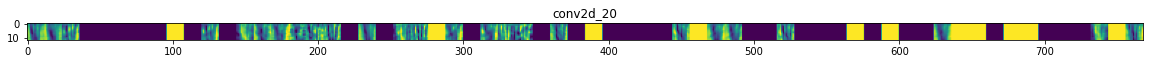

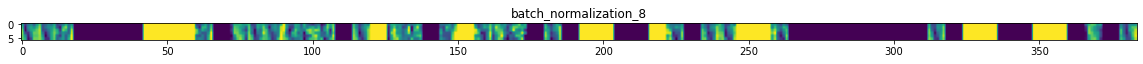

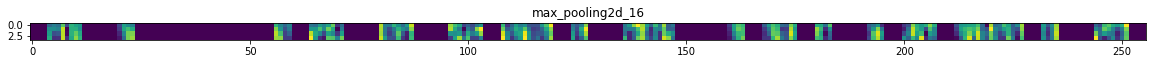

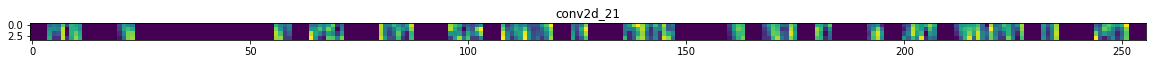

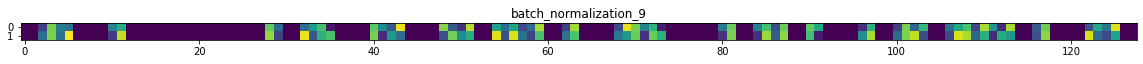

In [67]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np

img_path='train_images/blast_2.jpg' 
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(256, 256))
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

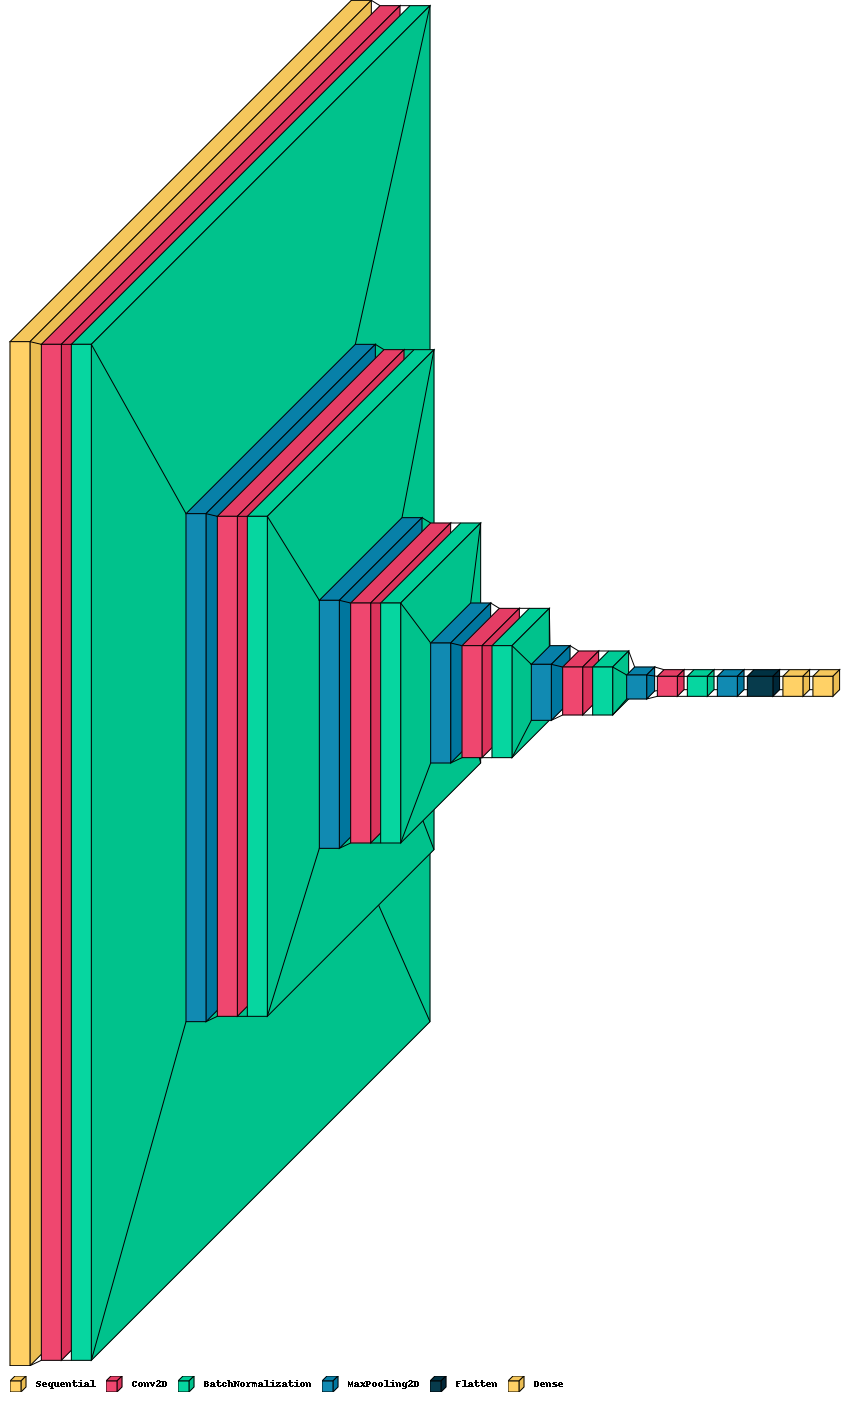

In [78]:

import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict


visualkeras.layered_view(model).show() 
visualkeras.layered_view(model, to_file='output.png') 
visualkeras.layered_view(model, to_file='output.png').show() 

from PIL import ImageFont

#font = ImageFont.truetype("C:\Windows\Fonts\Arial",32 )  # using comic sans is strictly prohibited!

model.add(visualkeras.SpacingDummyLayer(spacing=100))
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, color_map=color_map, legend=True,spacing=10)

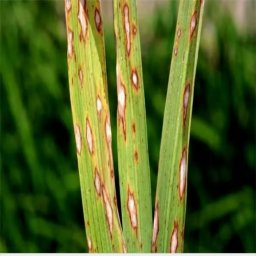

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n12985857', 'coral_fungus', 7.5420837)]


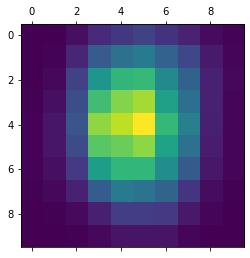

In [48]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"


# The local path to our target image
img_path = "train_images/blast_2.jpg"


display(Image(img_path))
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Run prediction on a sample image

first image to predict
actual label: hispa
1/1 [==============================] - 0s 255ms/step
predicted label: hispa


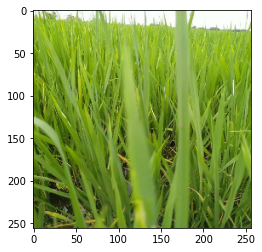

In [104]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    \
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 38ms/step


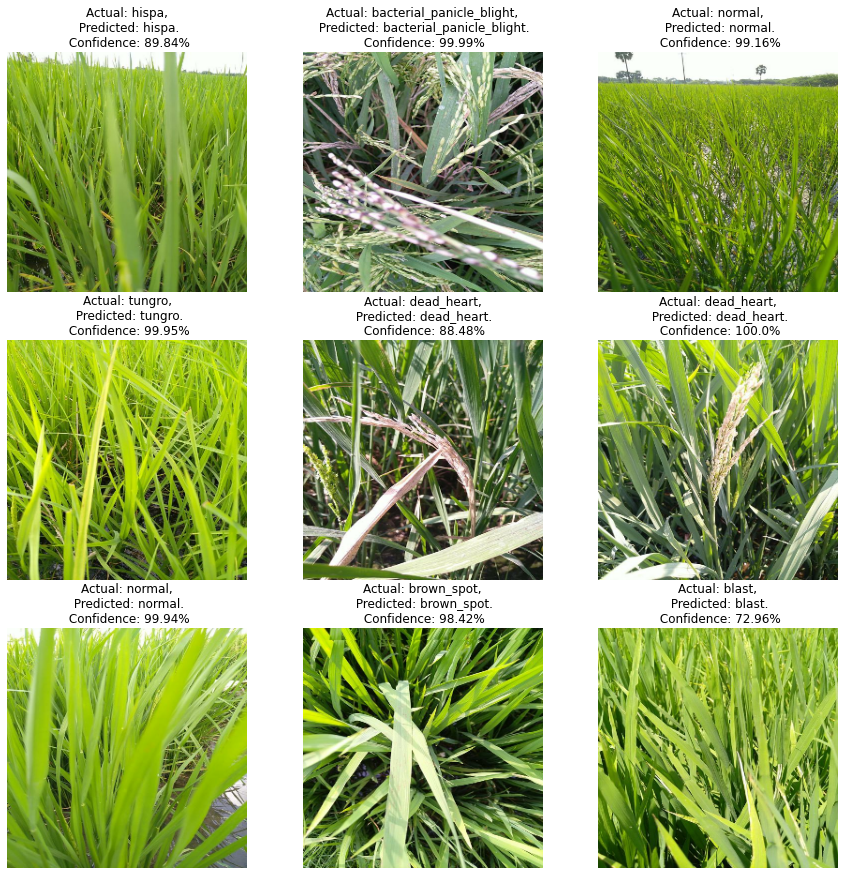

In [140]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [71]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{3}")


INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets


In [72]:
new_model = tf.keras.models.load_model('models/3')

# Check its architecture
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_5 (Batc  (None, 125, 125, 32)    